# Experiment 4 - Train models fine-tuning the VGG16 convolutional layers, pre-trained in ImageNet

In this experiment we train a VGG16-based model to perform classification using the Flowers Recognition dataset from Kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition). But this time freezing *just some* of the convolutional layers from the VGG16 pre-trained using the ImageNet dataset.

We'll perform the same steps as before to find the best performance as possible using this architecture, fine-tuning part of the VGG layers and training the fully-connected layers from zero.

The results obtained here will be used later to compare with the future experiments.

In [ ]:
%tensorflow_version 1.x
import os
import numpy as np
import tensorflow as tf
import random as rn
import keras
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from os import walk
from tqdm import *
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Reshape, Conv2D, Dropout, Activation, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Set some variables to allow reproducibility

In [2]:
os.environ["PYTHONHASHSEED"] = "0"
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

## Download the flowers dataset from kaggle

### Set kaggle username and key

In [10]:
os.environ["KAGGLE_USERNAME"] = "{username}"
os.environ["KAGGLE_KEY"] = "{key}"

### Download using the Kaggle API

https://www.kaggle.com/docs/api

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip
!rm flowers-recognition.zip
!rm -f 'flowers/dandelion/flickr.py'
!rm -f 'flowers/dandelion/flickr.pyc'
!rm -f 'flowers/dandelion/run_me.py'
!rm -rf 'flowers/flowers'

## Organize data and split into train, validation and test

In [12]:
dataset_path = 'flowers'
for (dirpath, dirnames, filenames) in walk(dataset_path):
    if (len(dirnames) > 0):
        folders_with_labels =  np.empty([len(dirnames), 3], dtype=object)
        i = 0
        for dir_name in sorted(dirnames, key=str.lower):
            folders_with_labels[i][0] = dir_name
            folders_with_labels[i][1] = i
            folders_with_labels[i][2] = []
            i += 1
print(folders_with_labels)

for path, label, imgs in folders_with_labels:
    for (dirpath, dirnames, filenames) in walk(os.path.join(dataset_path, path)):
        for file_name in filenames:
            imgs.append('{}/{},{}'.format(path, file_name, label))
            
print('-----------------------')
print("Total images per class...")
total = 0
for path, label, imgs in folders_with_labels:
    print(path, ":", len(imgs))
    total += len(imgs)
print('-----------------------')
print('Total of images:', total)

split_validation = 170
split_test = 170
train = []
val = []
test = []
for path, label, imgs in folders_with_labels:
    test.extend(imgs[0:split_test])
    val.extend(imgs[split_test:split_test+split_validation])
    train.extend(imgs[split_test+split_validation:len(imgs)])
    
print('-----------------------')
print('Total per set...')
print('x_train:', len(train))
print('x_test:', len(test))
print('x_val:', len(val))

from random import shuffle
shuffle(test)
shuffle(val)
shuffle(train)

print('-----------------------')
with open(os.path.join(dataset_path, 'test.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in test)
    print('File test.txt created.')
    
with open(os.path.join(dataset_path, 'val.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in val)
    print('File val.txt created.')
    
with open(os.path.join(dataset_path, 'train.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in train)
    print('File train.txt created.')

[['daisy' 0 list([])]
 ['dandelion' 1 list([])]
 ['rose' 2 list([])]
 ['sunflower' 3 list([])]
 ['tulip' 4 list([])]]
-----------------------
Total images per class...
daisy : 769
dandelion : 1052
rose : 784
sunflower : 734
tulip : 984
-----------------------
Total of images: 4323
-----------------------
Total per set...
x_train: 2623
x_test: 850
x_val: 850
-----------------------
File test.txt created.
File val.txt created.
File train.txt created.


### Set initial parameters, functions and generators

Set parameters for our model and training

In [3]:
dataset_path = 'flowers'
width = 224
height = 224
input_shape = (width, height, 3)
batch_size = 10
verbose = 1
classes_dict = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

Here we define 3 functions:


*   read_training_file() : Read the paths to images and labels for the dataset using each file (train, validation and test).
*   preprocess_image() : Preprocess the images in batch, set the size, the type and put in the TF format (scale pixels between -1 and 1).
*   data_generator() : Returns a generator that reads the images in batch and call the preprocess function, to be used in the training process with the fit_generator function.



In [4]:
def read_training_file(path, separator=' '):
    images = []
    labels = []
    with open(path, 'r') as f:
        for i in tqdm(f.readlines()):
            img_name, cls = i.strip().split(separator)
            cls = int(cls)
            images.append(img_name)
            labels.append(cls)
    return images, labels

def preprocess_image(images, images_path, width, height):
    pp_images = []

    for image in images:
        img = cv2.imread(os.path.join(images_path, image))
        if img.shape[0] != 224 or img.shape[1] != 224:
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
        img = np.asarray(img, 'float32')
        img = preprocess_input(img, mode='tf')
        pp_images.append(img)

    return np.asarray(pp_images)

def data_generator(images, labels, batch_size, images_path, width, height):
    batch_start = 0
    while batch_start < len(images):
        batch_end = min(batch_start + batch_size, len(images))
        y_batch = labels[batch_start : batch_end]
        x_batch = preprocess_image(images[batch_start : batch_end],
                                   images_path,
                                   width,
                                   height)
        batch_start += batch_size
        if batch_start >= len(images):
            batch_start = 0
        yield (x_batch, y_batch)

Read the label files (train, val and test) and set two arrays:

1.   paths to images.
2.   labels as a binary class matrix, for use with categorical_crossentropy.



In [5]:
train_path = os.path.join(dataset_path, 'train.txt')
val_path = os.path.join(dataset_path, 'val.txt')
test_path = os.path.join(dataset_path, 'test.txt')

train_images, train_labels = read_training_file(train_path, ',')
val_images, val_labels = read_training_file(val_path, ',')
test_images, test_labels = read_training_file(test_path, ',')

print('Train: {} documents'.format(len(train_images)))
print('Validation: {} documents'.format(len(val_images)))
print('Test: {} documents'.format(len(test_images)))

train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)
test_labels_one_hot = to_categorical(test_labels)
print(train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape)

100%|██████████| 850/850 [00:00<00:00, 465182.46it/s]

Train: 2623 documents
Validation: 850 documents
Test: 850 documents
(2623, 5) (850, 5) (850, 5)


Create generators for the training set and validation set.

In [6]:
train_gen = data_generator(train_images, train_labels_one_hot, batch_size, dataset_path, width, height)
val_gen = data_generator(val_images, val_labels_one_hot, batch_size, dataset_path, width, height)

num_batches_per_epoch = int(round(len(train_images) / float(batch_size)))
num_batches_per_epoch_val = int(round(len(val_images) / float(batch_size)))

## 1 - Fine-tuning VGG16 with 2 FC layers

### Define and compile the model architecture

In [7]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [8]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_1: <keras.engine.input_layer.InputLayer object at 0x7f08e0065438>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08d080b0f0>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7f08d080b2e8>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f08d07815c0>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08d0781d30>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7f08d073a668>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f08d073acc0>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08d0754828>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7f08bf97f1d0>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7f08bf97fac8>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f08bf936eb8>
flatten: <keras.layers.core.Flatten object at 0x7f08e00654a8>

Trainable
block4_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08bf936a20>
block4_conv2: <kera

In [9]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [11]:
model.save('4_vgg16_fine_tuning_model1.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

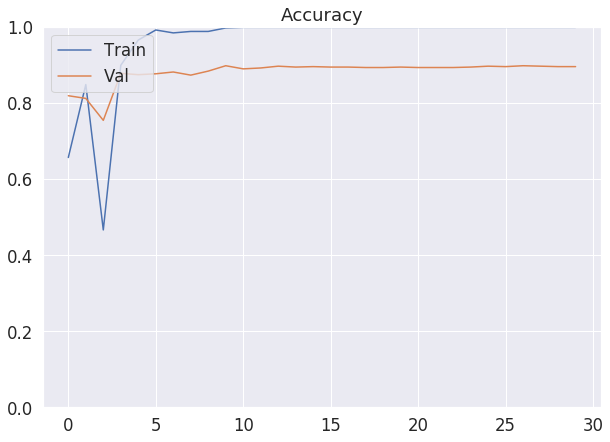

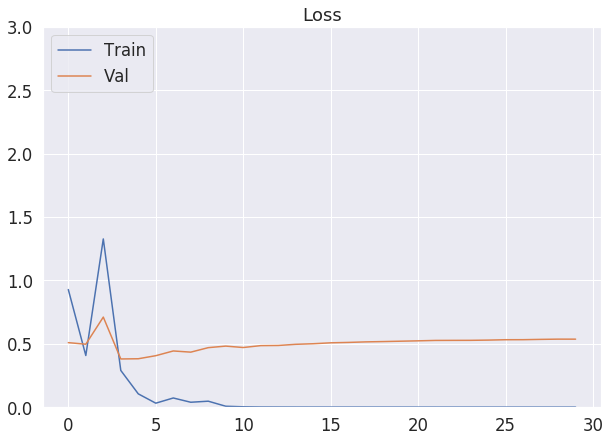

In [12]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

### Generate the classification report from the test set.

85/85 [==============================] - 7s 81ms/step
              precision    recall  f1-score   support

       daisy       0.95      0.89      0.92       170
   dandelion       0.86      0.96      0.91       170
        rose       0.88      0.80      0.84       170
   sunflower       0.96      0.89      0.93       170
       tulip       0.81      0.90      0.85       170

    accuracy                           0.89       850
   macro avg       0.89      0.89      0.89       850
weighted avg       0.89      0.89      0.89       850



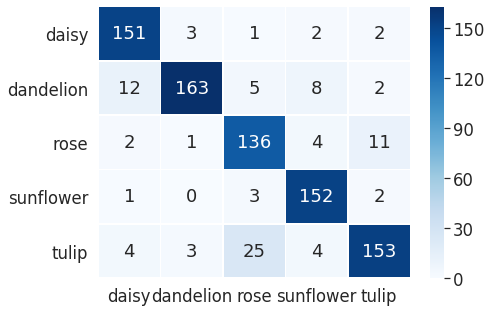

In [14]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()

## 2 - Fine-tuning VGG16 with 2 FC layers + Regularization

### Define and compile our basic model architecture

In [15]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [16]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_2: <keras.engine.input_layer.InputLayer object at 0x7f0848e93fd0>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7f084937ca20>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7f084937ceb8>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f0848e50dd8>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7f0848e507b8>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7f0848e7fb00>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f0848e19e10>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7f0848e19eb8>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7f0848dcf8d0>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7f0848deab00>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f0848e01f60>
flatten: <keras.layers.core.Flatten object at 0x7f0848c54f98>
dropout_1: <keras.layers.core.Dropout object at 0x7f0848c98d68>
dropout_2: <keras.layers.core.Dropout obj

In [17]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [19]:
model.save('4_vgg16_fine_tuning_model2.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

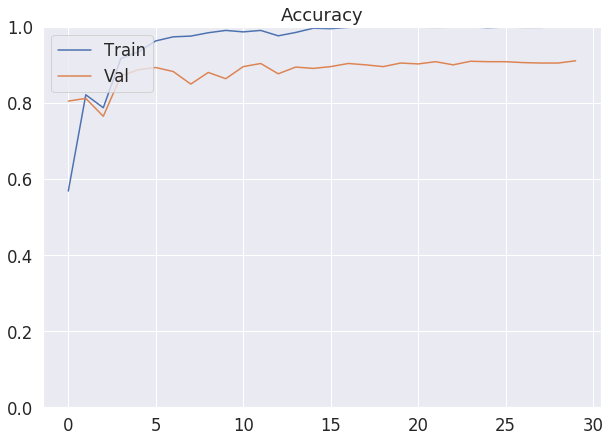

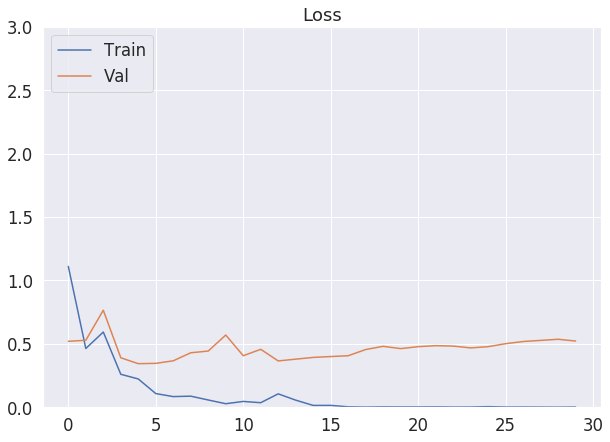

In [20]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

### Generate the classification report from the test set.

85/85 [==============================] - 7s 81ms/step
              precision    recall  f1-score   support

       daisy       0.97      0.91      0.94       170
   dandelion       0.87      0.95      0.91       170
        rose       0.90      0.82      0.86       170
   sunflower       0.93      0.92      0.93       170
       tulip       0.84      0.89      0.86       170

    accuracy                           0.90       850
   macro avg       0.90      0.90      0.90       850
weighted avg       0.90      0.90      0.90       850



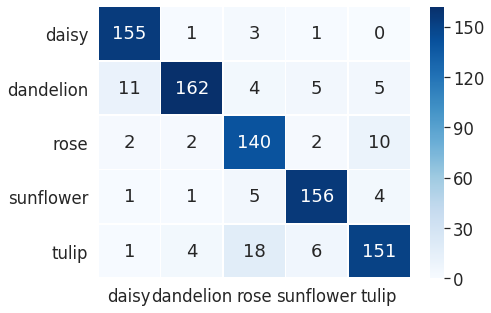

In [22]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()

## 3 - Fine-tuning VGG16 with 2 FC layers + Regularization + Augmentation

### Create augmentation generator

Here we use the ImageDataGenerator from Keras to apply different types of augmentation.

In [23]:
image_gen = ImageDataGenerator(zoom_range=0.3,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [24]:
def augmentation_generator(in_generator):

    for in_x, in_y in in_generator:
        g_x = image_gen.flow(255*in_x, in_y,
                             batch_size=in_x.shape[0])
        x, y = next(g_x)

        yield x/255.0, y

In [25]:
train_gen = augmentation_generator(train_gen)
val_gen = augmentation_generator(val_gen)

### Define and compile the model architecture

In [26]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [27]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_3: <keras.engine.input_layer.InputLayer object at 0x7f0848501a90>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08485018d0>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7f0848501dd8>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f084849de48>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7f084849def0>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7f08484ba978>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f08483dfbe0>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7f08483dfd68>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7f084839a4e0>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7f08483b5cf8>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f08483ccfd0>
flatten: <keras.layers.core.Flatten object at 0x7f0848501908>
dropout_3: <keras.layers.core.Dropout object at 0x7f0848279f28>
dropout_4: <keras.layers.core.Dropout obj

In [28]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model.

In [29]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

Start training...
Epoch 1/30
262/262 [==============================] - 65s 249ms/step - loss: 1.3253 - acc: 0.4517 - val_loss: 0.8222 - val_acc: 0.6635
Epoch 2/30
262/262 [==============================] - 63s 241ms/step - loss: 0.7006 - acc: 0.7394 - val_loss: 0.5563 - val_acc: 0.8047
Epoch 3/30
262/262 [==============================] - 63s 239ms/step - loss: 0.5518 - acc: 0.8024 - val_loss: 0.6210 - val_acc: 0.7635
Epoch 4/30
262/262 [==============================] - 63s 241ms/step - loss: 0.3820 - acc: 0.8641 - val_loss: 0.4401 - val_acc: 0.8529
Epoch 5/30
262/262 [==============================] - 63s 240ms/step - loss: 0.3048 - acc: 0.9000 - val_loss: 0.4093 - val_acc: 0.8776
Epoch 6/30
262/262 [==============================] - 63s 240ms/step - loss: 0.2520 - acc: 0.9141 - val_loss: 1.8275 - val_acc: 0.5871
Epoch 7/30
262/262 [==============================] - 63s 240ms/step - loss: 0.2977 - acc: 0.8912 - val_loss: 0.5424 - val_acc: 0.8471
Epoch 8/30
262/262 [=================

In [30]:
model.save('4_vgg16_fine_tuning_model3.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

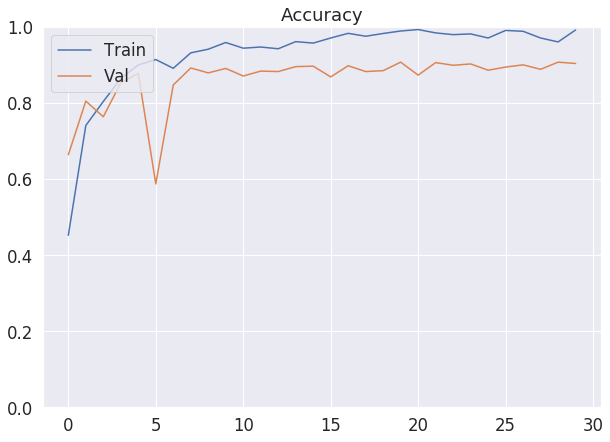

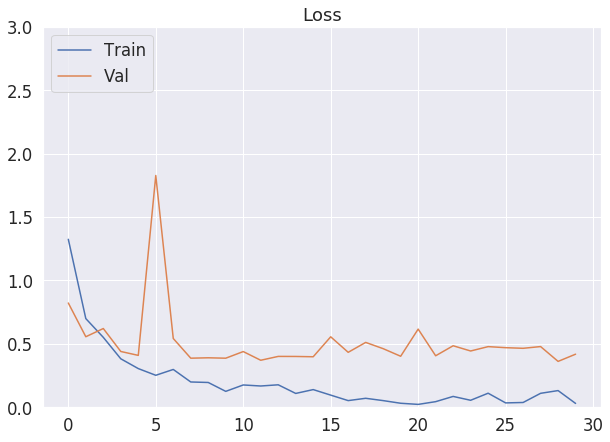

In [31]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [32]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

Evaluating trained model...
Finished mobilenet.evaluate_generator
['loss', 'acc']
[0.4179920466008779, 0.907058816797593]


### Generate the classification report from the test set.

85/85 [==============================] - 7s 82ms/step
              precision    recall  f1-score   support

       daisy       0.96      0.91      0.93       170
   dandelion       0.95      0.93      0.94       170
        rose       0.87      0.86      0.87       170
   sunflower       0.92      0.95      0.93       170
       tulip       0.85      0.89      0.87       170

    accuracy                           0.91       850
   macro avg       0.91      0.91      0.91       850
weighted avg       0.91      0.91      0.91       850



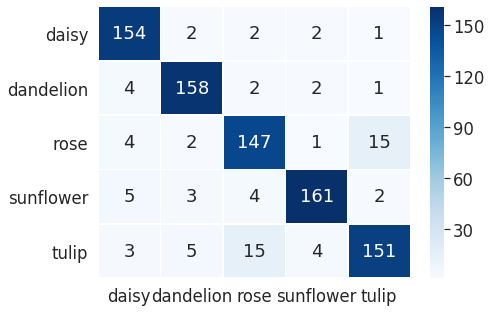

In [33]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()